In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from tqdm.auto import tqdm

In [2]:
# torch.rand(10, 12, 32, 15).transpose(1, 3).shape

In [3]:
# SRC: https://github.com/chenmingxiang110/Growing-Neural-Cellular-Automata/blob/master/lib/CAModel.py
class CAModel(nn.Module):
    def __init__(self, channel_n, fire_rate, device, hidden_size=128):
        super(CAModel, self).__init__()

        self.device = device
        self.channel_n = channel_n

        self.fc0 = nn.Linear(channel_n * 3, hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, channel_n, bias=False)
        init.zeros_(self.fc1.weight)

        self.fire_rate = fire_rate
        self.to(self.device)

    def alive(self, x):
        return F.max_pool2d(x[:, :1, :, :], kernel_size=3, stride=1, padding=1) > 0.1

    def perceive(self, x, angle):

        def _perceive_with(x, weight):
            conv_weights = torch.from_numpy(weight.astype(np.float32)).to(self.device)
            conv_weights = conv_weights.view(1, 1, 3, 3).repeat(self.channel_n, 1, 1, 1)
            return F.conv2d(x, conv_weights, padding=1, groups=self.channel_n)

        dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
        dy = dx.T
        c = np.cos(angle * np.pi / 180)
        s = np.sin(angle * np.pi / 180)
        w1 = c * dx - s * dy
        w2 = s * dx + c * dy

        y1 = _perceive_with(x, w1)
        y2 = _perceive_with(x, w2)
        y = torch.cat((x, y1, y2), 1)
        return y

    def update(self, x, fire_rate, angle):
        x = x.transpose(1, 3)
        pre_life_mask = self.alive(x)

        dx = self.perceive(x, angle)
        dx = dx.transpose(1, 3)
        dx = self.fc0(dx)
        dx = F.relu(dx)
        dx = self.fc1(dx)
        dx = F.relu(dx)
        dx = self.fc2(dx)

        if fire_rate is None:
            fire_rate = self.fire_rate
        stochastic = torch.rand([dx.size(0), dx.size(1), dx.size(2), 1]) > fire_rate
        stochastic = stochastic.float().to(self.device)
        dx = dx * stochastic

        x = x + dx.transpose(1, 3)
#         x = torch.tanh(dx.transpose(1, 3))

        post_life_mask = self.alive(x)
        life_mask = (pre_life_mask & post_life_mask).float()
        x = x * life_mask
        return x.transpose(1, 3)

    def forward(self, x, steps=1, fire_rate=None, angle=0.0):
        x = x.transpose(1, 3)
        seq = [x.transpose(1, 3)]
        for step in range(steps):
            x = self.update(x, fire_rate, angle)
            seq.append(x.transpose(1, 3))
        return seq

In [4]:
class Encoder(nn.Module):
    def __init__(self, msg_size, body_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(msg_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, body_size * body_size),
        )
        self.body_size = body_size

    def forward(self, x):
        x = self.net(x)
        x = x.reshape(-1, 1, self.body_size, self.body_size)
        return x

In [5]:
class Decoder(nn.Module):
    def __init__(self, hid, seed_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=0, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=0, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=5, padding=0, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=5, padding=0, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256, seed_size)
        )

    def forward(self, x):
        return self.net(x)

In [6]:
CHANS = 8
DNA_SIZE = 16
FIRE_RATE = 1
device = "cuda"
HIDDEN_SIZE = 128
DECODER_HID = 128
BODY_SIZE = 14
BS = 32
SIZE = 32 # W,H
LR = 0.001

In [7]:
dna = torch.rand(BS, DNA_SIZE)
encoder = Encoder(DNA_SIZE, BODY_SIZE)
body = encoder(dna)
body.shape

torch.Size([32, 1, 14, 14])

In [8]:
def place_body_into_world(body):
    world = torch.zeros(BS, CHANS, SIZE, SIZE * 2)
    world[
        :, :1,
        SIZE // 2 - BODY_SIZE // 2 : SIZE // 2 - BODY_SIZE // 2 + BODY_SIZE,
        SIZE // 2 - BODY_SIZE // 2 : SIZE // 2 - BODY_SIZE // 2 + BODY_SIZE
    ] = body
    return world

In [9]:
world = place_body_into_world(body)
world.shape

torch.Size([32, 8, 32, 64])

In [10]:
# media.show_image(world[3, 4].detach(), cmap="viridis", width=200)

In [11]:
im = torch.rand(32, 1, 32, 32).to(device)
decoder = Decoder(DECODER_HID, CHANS).to(device)
res = decoder(im)
res.shape

torch.Size([32, 8])

In [12]:
model = CAModel(CHANS, FIRE_RATE, device=device, hidden_size=HIDDEN_SIZE)
decoder = Decoder(DECODER_HID, CHANS).to(device)

# Sanity check
inp = torch.rand(BS, CHANS, SIZE, SIZE).to(device)
seq = model(inp, steps=15)
last_frame = seq[-1]
last_frame_slice = last_frame[:, :1]
last_frame_slice.shape
decoded_hid = decoder(last_frame_slice)
decoded_hid.shape

torch.Size([32, 8])

In [13]:
# !pip install kornia

# !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
# !pip install -q mediapy

import kornia
import mediapy as media

In [14]:
noise = nn.Sequential(
    kornia.augmentation.RandomAffine(
        degrees=5,
        translate=[0.01, 0.01],
        scale=[0.9, 1.1],
        shear=[-10, 10],
        p=0.9,
    ),
    kornia.augmentation.RandomErasing(
        scale=(0.05, 0.1), ratio=(0.5, 2),
        value=0.0, same_on_batch=False, p=0.5, keepdim=False
    ),
    kornia.augmentation.RandomGaussianNoise(0, 0.01, p=1),
).to(device)

In [15]:
screen = torch.rand(10, 16, 32, 32)
noised_screen = noise(screen)
noised_screen.shape

torch.Size([10, 16, 32, 32])

,,,,,,,,,

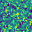
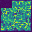
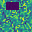
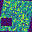
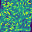
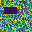
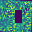
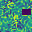
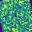
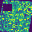

In [16]:
media.show_images(noised_screen[:, 0], border=True, height=150, cmap="viridis")

In [17]:
def generate_inputs(bs, chans, size):
    while True:
        screen = torch.zeros(bs, chans, size, size)
        seeds = torch.randn(bs, chans)
        screen[:, :, size//2, size//2] = seeds

        yield screen, seeds

In [18]:
input_gen = generate_inputs(BS, CHANS, SIZE)
batch = next(input_gen)
screen, seeds = batch
screen.shape, seeds.shape

(torch.Size([32, 8, 32, 32]), torch.Size([32, 8]))

In [19]:
# media.show_images(screen[:, 0], border=True, height=150, cmap="viridis")

In [20]:
batch = next(input_gen)
screen, seeds = batch
screen, seeds = screen.to(device), seeds.to(device)

seq = model(screen, steps=15)
last_frame = seq[-1]
last_frame_slide = last_frame[:, :1]
noised_last_frame = noise(last_frame_slide)

decoded = decoder(noised_last_frame)
decoded.shape, seeds.shape

(torch.Size([32, 8]), torch.Size([32, 8]))

In [21]:
num_dna = 3

In [22]:
encoder = Encoder(DNA_SIZE, BODY_SIZE).to(device)
model = CAModel(CHANS, FIRE_RATE, device=device, hidden_size=HIDDEN_SIZE)
decoder = Decoder(DECODER_HID, num_dna).to(device)
input_gen = generate_inputs(BS, CHANS, SIZE)
history = []

In [23]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

def to_numpy(t):
    return t.detach().cpu().numpy()

In [24]:
xx = torch.arange(BODY_SIZE*1)
yy = torch.arange(BODY_SIZE*1)
grid = torch.stack(torch.meshgrid([xx, yy]), axis=-1) / ((BODY_SIZE - 1) / 2)
x = grid[:,:,0] - 1
y = grid[:,:,1] - 1
grid = torch.sqrt(x * x + y * y)
mask = 1 - torch.clamp(grid, 0.8, 1)
media.show_image(mask, width=100, cmap="viridis")

/home/iz/.cache/pypoetry/virtualenvs/nca-ar8j7Liq-py3.10/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


""


In [25]:
dna = torch.randn(BS, DNA_SIZE).to(device)
body = encoder(dna) * mask.to(device)
world = place_body_into_world(body)
S = np.random.randint(4, 50)

seq = model(world.to(device), steps=S)
# last_frame = seq[-1][:, :1, :, SIZE : SIZE*2]
# noised_last_frame = noise(last_frame)
# normal_noise = torch.randn_like(noised_last_frame) / 30
# noised_last_frame += normal_noise
# decoded = decoder(noised_last_frame)

""

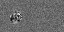

In [26]:
media.show_image(noise(seq[0][:, :1])[0, 0].detach().cpu(),width=200)

In [27]:
# last_frame1_masses.mean()
emb = nn.Embedding(num_dna, DNA_SIZE).to(device)

Loss: 3.29611:  93%|#########3| 93250/100000 [3:12:32<10:34, 10.64it/s]

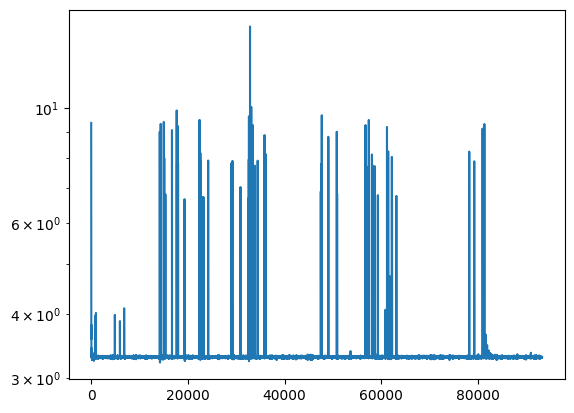

,,,,,,,,,

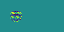
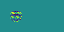
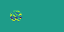
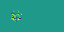
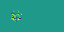
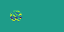
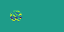
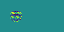
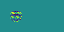
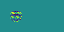

,,,,
,,,,

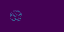
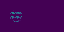
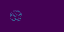
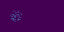
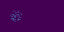
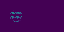
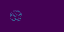
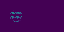
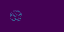
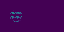

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [28]:
optim = torch.optim.Adam([
    *model.parameters(), *encoder.parameters(),
    *decoder.parameters(), *emb.parameters()
], lr=LR)
pbar = tqdm(range(100000))

for i in pbar:
    S = np.random.randint(50, 51)

#     dna = torch.rand(BS, DNA_SIZE).to(device)
    dna_id = torch.randint(0, num_dna, size=(BS,)).to(device)
    dna = emb(dna_id)
    body = encoder(dna) * mask.to(device)
    world = place_body_into_world(body).to(device)
    initial_masses = world.sum(axis=[1, 2, 3])

    seq = model(world, steps=S)

    loss = 0
    for j in range(0, S - 10, 5):
        frame = seq[j][:, :1, :, j : j + SIZE]
#         frame = noise(frame)
        loss += F.cross_entropy(decoder(frame), dna_id)

        abs_frame = torch.abs(frame)
        peaks = abs_frame[abs_frame > 1.1]
        if len(peaks) > 0:
            loss += peaks.mean()

#         frame_mass = frame.mean(axis=[1,2,3])
#         mass_target = torch.full_like(frame_mass, 10.0).to(device)
#         loss += F.mse_loss(frame_mass, mass_target)

    optim.zero_grad()

    loss.backward()
    optim.step()
    history.append(loss.item())

    pbar.set_description(f"Loss: {loss.item():0.5f}")
    if i % 250 == 0:
        clear_output()

        display(pbar.container)

        plt.plot(history)
        plt.yscale("log")
        plt.show()

        media.show_images(
            to_numpy(seq[-1][:10, 0]), border=True,
            height=100, cmap="viridis", columns=10
        )
        
        dna_id = torch.randint(0, num_dna, size=(BS,)).to(device)
        dna = emb(dna_id)
        body = encoder(dna) * mask.to(device)
        world = place_body_into_world(body).to(device)
        seq = model(world, steps=100)
        media.show_videos(
            media.to_rgb(
                to_numpy(torch.stack(seq).transpose(0, 1)[:10,:,0]), cmap="viridis",
                vmin=0, vmax=1
            ),
            height=150, fps=10, codec='gif', border=True, columns=5 
        )

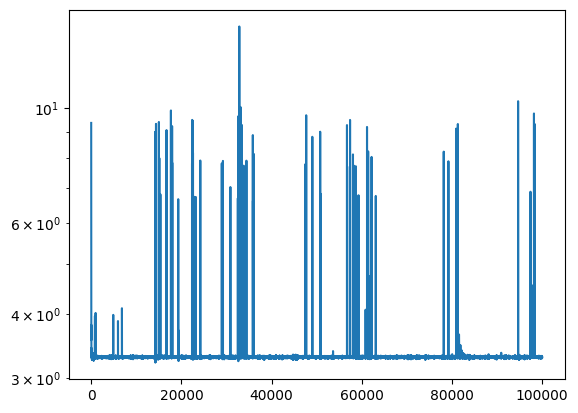

,,,,,,,,,

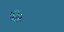
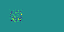
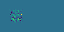
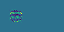
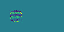
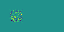
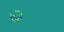
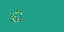
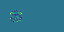
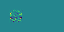

,,,,
,,,,

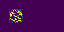
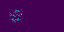
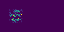
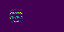
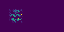
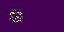
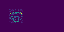
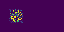
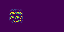
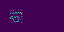

In [33]:
plt.plot(history)
plt.yscale("log")
plt.show()

media.show_images(
    to_numpy(
        seq[-1][:10, 0]), border=True,
        height=100, cmap="viridis", columns=10
)

dna = torch.randn(BS, DNA_SIZE).to(device)
body = encoder(dna)
world = place_body_into_world(body).to(device)
seq = model(world, steps=100)
media.show_videos(
    media.to_rgb(
        to_numpy(torch.stack(seq).transpose(0, 1)[:10,:,0]),
        vmin=0, vmax=1, cmap="viridis"
    ),
    height=150, fps=30, codec='gif', border=True, columns=5
)

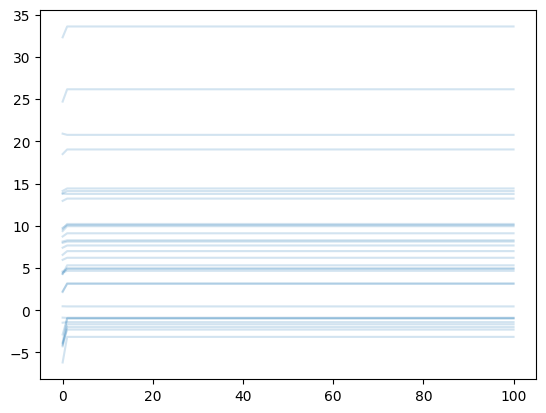

In [34]:
m = to_numpy(torch.stack(seq).transpose(0, 1))
b,s,c,h,w = m.shape
merged = m.reshape(b,s,c*h*w)
ma = abs(merged).max(axis=-1)
mean = merged.mean(axis=-1)
s = merged.sum(axis=-1)
for x in s:
    plt.plot(x, c="tab:blue", alpha=0.2)

In [31]:
# first_frame_decoded

In [32]:
from datetime import datetime
import os

now = datetime.now()
save_dir = "./saved"
os.makedirs(save_dir, exist_ok=True)

nca_path = os.path.join(save_dir, f"nca_{now}.pkl")
decoder_path = os.path.join(save_dir, f"nca_{now}.pkl")

with open(nca_path) as fp:
    torch.save(mdoel, fp)
with open(decoder_path) as fp:
    torch.save(mdoel, fp)

FileNotFoundError: [Errno 2] No such file or directory: './saved/nca_2025-03-29 02:08:53.417794.pkl'

In [ ]:
batch = next(input_gen)
screen, seeds = batch

S = np.random.randint(4, 50)

seq = model(screen.to(device), steps=100)

In [ ]:
§i.show_videos(
    to_numpy(torch.stack(seq).transpose(0, 1)[:,:,0]),
    height=100, fps=8, codec='gif', border=True, columns=16
)

In [ ]:
input_gen_small = generate_inputs(5, CHANS, SIZE)
batch = next(input_gen_small)
screen, seeds = batch

S = 100

seq = model(screen.to(device), steps=S)
media.show_videos(
    media.to_rgb(to_numpy(torch.stack(seq).transpose(0, 1)[:,:,0]), vmin=0, vmax=1, cmap="viridis"),
    height=150, fps=20, codec='gif', border=True, columns=16
)

In [ ]:
batch = next(input_gen)
screen, seeds = batch

S = 50

seq = model(screen.to(device), steps=S // 2)
last_frame = seq[-1]
noised_last_frame = noise(last_frame)
normal_noise = torch.randn_like(noised_last_frame) / 30
# noised_last_frame += normal_noise

seq2 = model(noised_last_frame, steps=S // 2)

In [ ]:
media.show_videos(
    media.to_rgb(to_numpy(torch.stack(seq + seq2).transpose(0, 1)[:,:,0]), vmin=0, vmax=1, cmap="viridis"),
    height=100, fps=20, codec='gif', border=True, columns=16
)